# Assignment 4

#### Import and Inits

In [11]:
import h2o                                                        
from h2o.backend import H2OLocalServer                            
from h2o.estimators.random_forest import H2ORandomForestEstimator 
from interpret.glassbox import ExplainableBoostingClassifier      
from interpret.perf import ROC                                    
import matplotlib.pyplot as plt                                   
import numpy as np                                                                            
import pandas as pd                                               
import subprocess                                                 
import time                                                       

from IPython.display import Image
from IPython.display import display

SEED = 12345 
np.random.seed(SEED)

NTHREAD = 4

h2o.init(max_mem_size='2G') 
h2o.remove_all()                 
h2o.no_progress()                 


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,8 mins 36 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_matia_w9ul7t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.757 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Defining Utility Functions

#### Creating a utility function that trains a cross-validated (CV) decision tree

In [12]:
def get_cv_dt(x, y, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    tree = H2ORandomForestEstimator(ntrees=1,  
                                    sample_rate=1,
                                    mtries=-2,  
                                    max_depth=4,  
                                    seed=seed_,  
                                    nfolds=3,  
                                    model_id=model_id)  

    if valid is not None:
        tree.train(x=x, y=y, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x, y=y, training_frame=h2o.H2OFrame(train))

    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    get_gv(title, model_id, mojo_path)
    get_png(model_id)

    return tree

#### Creating a utility function that converts H2O MOJO into graphviz file

In [13]:
def get_gv(title, model_id, mojo_path):
    
    """ Utility function to generate graphviz dot file from h2o MOJO using
        a subprocess.
        
    Args:
        title: Title for displayed decision tree.
        model_id: h2o model identifier.
        mojo_path: Path to saved model MOJO (Java scoring artifact);
                   generated by train_cv_dt function above.
    """

    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', title]

    print()
    print('Calling external process ...')
    print(' '.join(gv_args))

    _ = subprocess.call(gv_args)

#### Creating a utility function that converts graphviz file into PNG

In [14]:
def get_png(model_id):

    """ Utility function to generate PNGs from .dots using a subprocess.
    Arg:
        model_id: h2o model identifier.
    """

    gv_file_name = model_id + '.gv'

    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    print('Calling external process ...')
    print(' '.join(png_args))

    _ = subprocess.call(png_args)

#### Global timer starts

In [15]:
tic = time.time()

#### Importing data

In [16]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assigning basic modeling roles

In [17]:
y = 'high_priced'

### Fitting Interpretable Model

#### Splitting data into training and validation partitions

In [18]:
np.random.seed(SEED)

split_ratio = 0.7 

split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine (EBM)

#### Retraining most accurate model above 0.8 AIR to act as blackbox prediction API

In [19]:
rem_params = {'max_bins': 512,
              'max_interaction_bins': 16,
              'interactions': 10,
              'outer_bags': 4,
              'inner_bags': 0,
              'learning_rate': 0.001,
              'validation_size': 0.25,
              'min_samples_leaf': 5,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD, 
              'random_state': SEED}

rem_x = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x], train[y]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x], valid[y])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7863.


### Model Extraction Attack

#### Generating synthetic data for extraction attack

In [20]:
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'}, 
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},  
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'}}

N = 10000 

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) 
                            
np.random.seed(SEED) 
    
for j in list(schema_dict.keys()): 
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)

    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)

    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std'] 

#### Visualizing simulated data

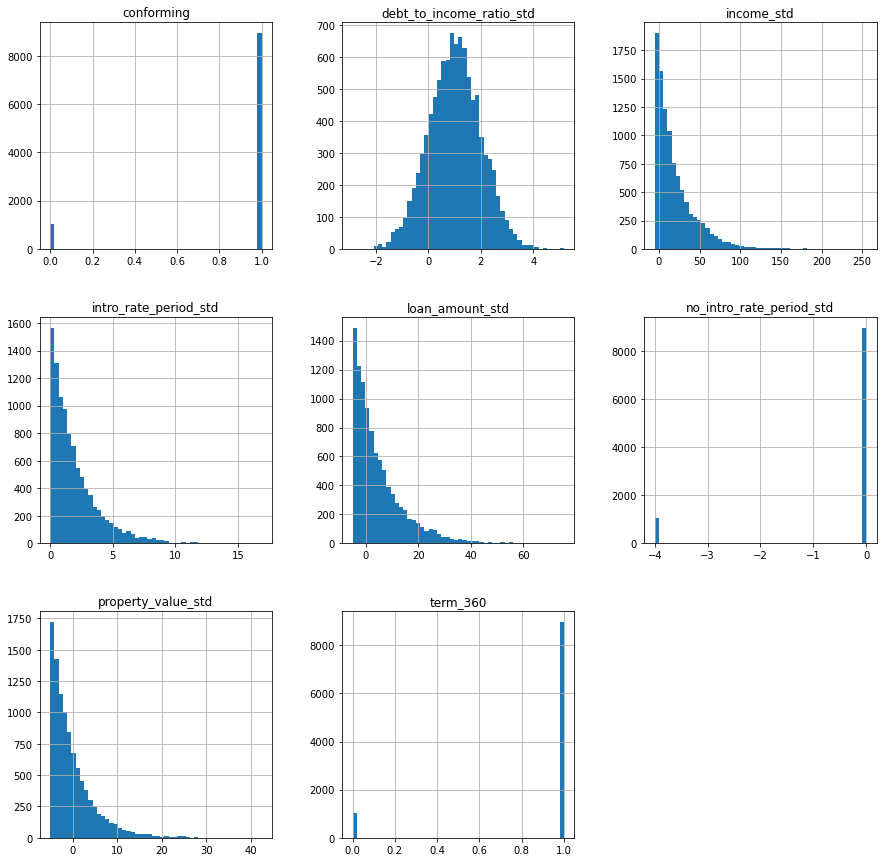

In [21]:
_ = random_frame[rem_x].hist(bins=50, figsize=(15, 15))

#### 1st call to blackbox model for predictions on random data

In [22]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x])[:, 1], columns=['phat']) 
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
0,0,1,0,7.848707,2.018107,4.448038,7.560986,2.346077,0.050927
1,1,1,-4,49.480298,1.029955,4.580346,-1.530707,0.239296,0.029750
2,1,1,0,0.014153,2.853882,8.899881,13.705550,0.639075,0.016135
3,1,1,0,7.912400,0.248822,8.887287,1.895881,0.087230,0.015524
4,1,1,0,-4.538403,1.796115,-2.252657,27.529353,1.263036,0.230014


#### Extracting a stolen decision tree model

In [23]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt', 
                      SEED, 
                      'Stolen Model')

Generated MOJO path:
 C:\Users\matia\Desktop\Assignment\stolen_dt.zip
Discovered H2O jar path:
 C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar

Calling external process ...
java -cp C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i C:\Users\matia\Desktop\Assignment\stolen_dt.zip -o stolen_dt.gv --title Stolen Model
Calling external process ...
dot -Tpng stolen_dt.gv -o stolen_dt.png


#### Stolen model

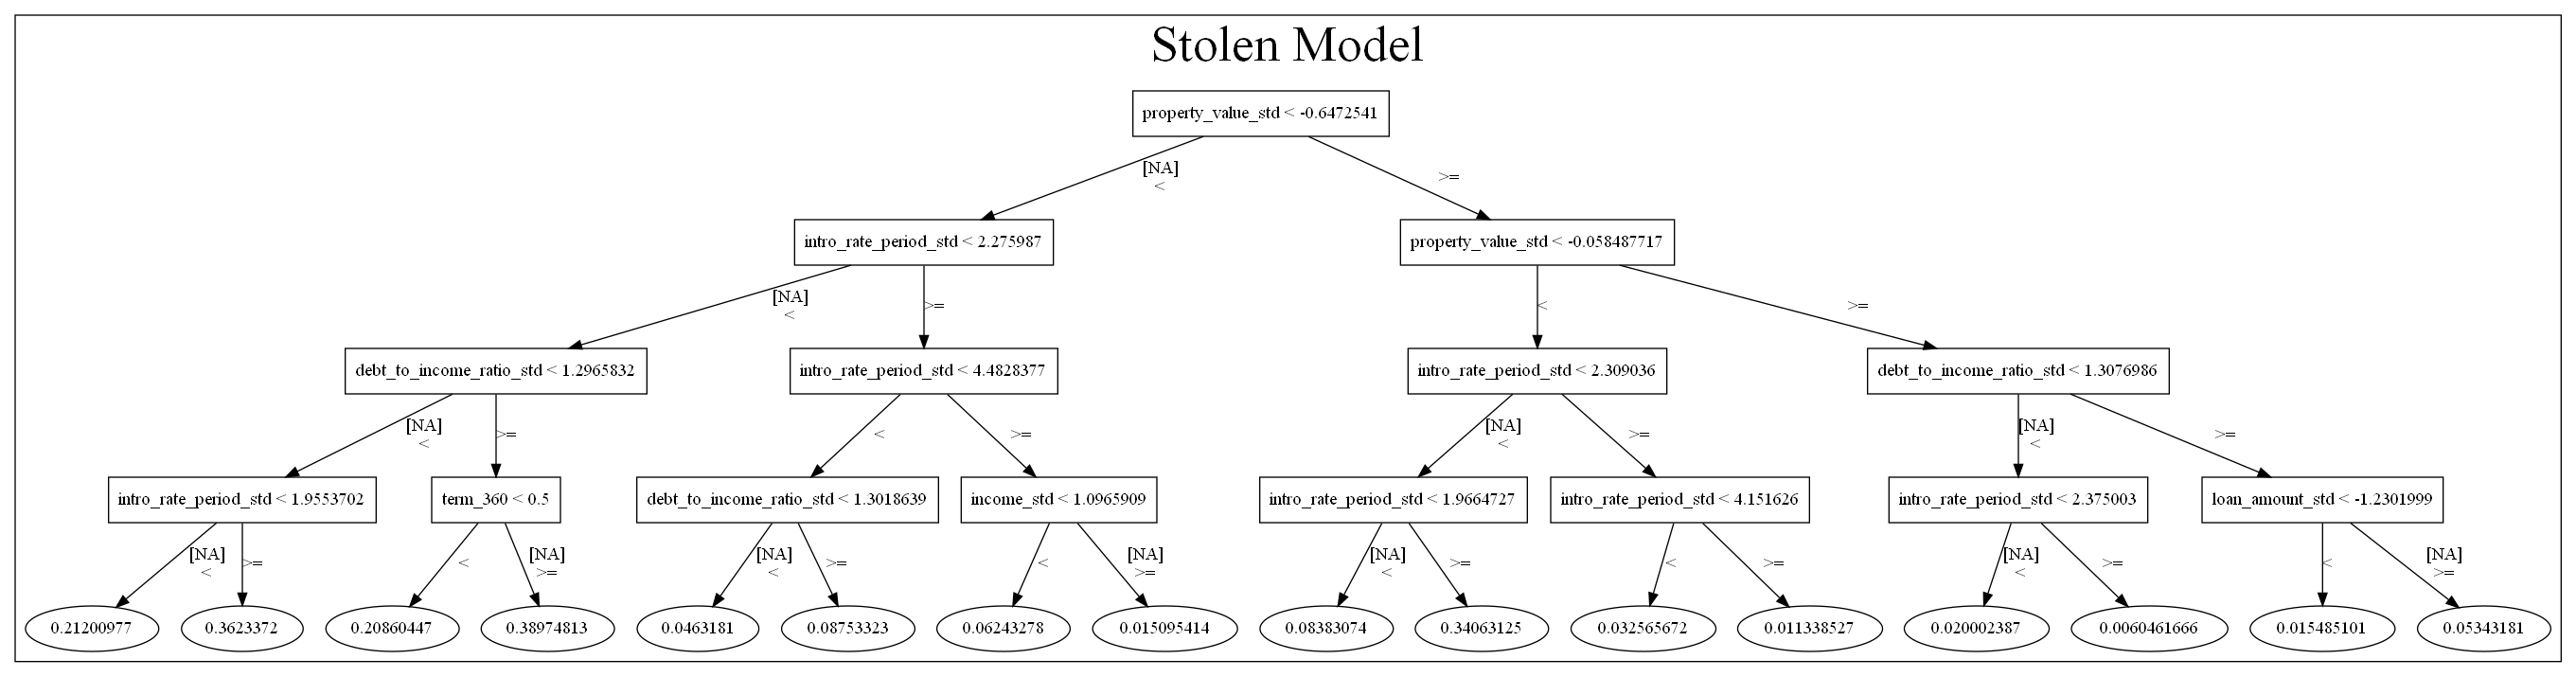

In [24]:
display(Image(('stolen_dt.png')))

#### Variable Importance for stolen model

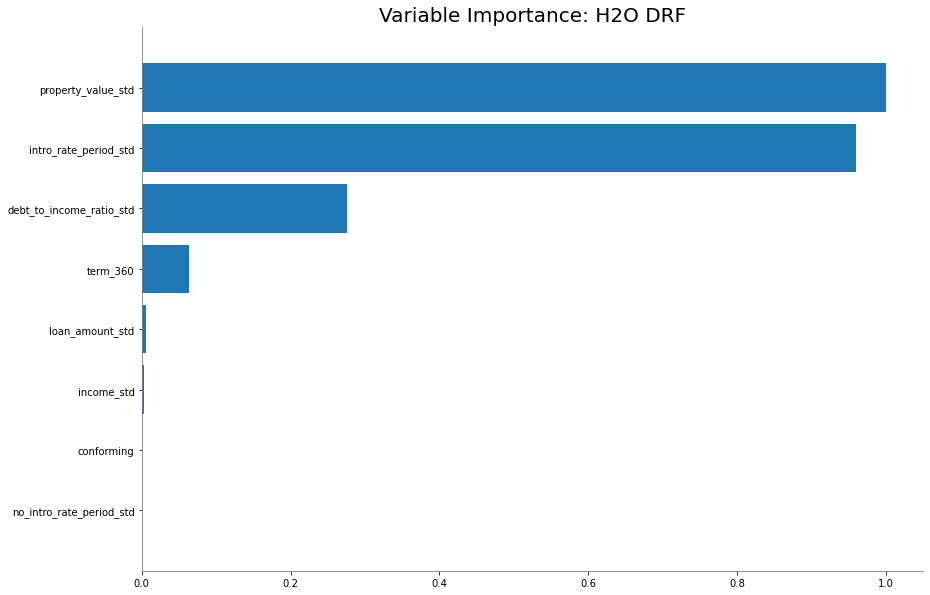

In [25]:
stolen_dt.varimp_plot()

#### Assessing accuracy of stolen model

In [26]:
stolen_dt.cross_validation_metrics_summary() 


Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
0,mae,0.041382544,7.9628365E-4,0.04226242,0.04071146,0.04117375
1,mean_residual_deviance,0.0046570576,6.0986324E-5,0.0047190334,0.0046550278,0.0045971116
2,mse,0.0046570576,6.0986324E-5,0.0047190334,0.0046550278,0.0045971116
3,r2,0.79076725,0.004630348,0.79114604,0.7859592,0.7951966
4,residual_deviance,0.0046570576,6.0986324E-5,0.0047190334,0.0046550278,0.0045971116
5,rmse,0.06824166,4.4677188E-4,0.068695225,0.06822776,0.067802005
6,rmsle,0.053953994,4.7952638E-4,0.05445822,0.053900033,0.053503733


### Using stolen model to craft adversarial examples

#### Using stolen model to find seed rows for adversary searches

In [27]:
low_adversary_seed = random_frame.loc[(random_frame['property_value_std'] >= -0.058) &
                                      (random_frame['debt_to_income_ratio_std'] < 1.308) & 
                                      (random_frame['intro_rate_period_std'] >= 2.375), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['property_value_std'] < -0.647) & 
                                       (random_frame['intro_rate_period_std'] < 2.28) & 
                                       (random_frame['debt_to_income_ratio_std'] >= 1.3) & 
                                       (random_frame['term_360'] >= 0.5), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                     0.907483
conforming                   0.895238
no_intro_rate_period_std    -0.451701
loan_amount_std              4.783837
intro_rate_period_std        4.258209
property_value_std           5.130546
income_std                  19.885581
debt_to_income_ratio_std     0.371789
dtype: float64

High adversarial example search seed row:
term_360                     1.000000
conforming                   0.889458
no_intro_rate_period_std    -0.412884
loan_amount_std              5.247810
intro_rate_period_std        0.924390
property_value_std          -3.060196
income_std                  19.735920
debt_to_income_ratio_std     1.995180
dtype: float64


#### Perturbing seed row to find low scoring adversarial examples

In [28]:
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5] 
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

for a in list(random_frame['property_value_std'].quantile(high_quantiles)): 
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['term_360'].quantile(low_quantiles)):
                    low_adversary_seed['property_value_std'] = a
                    low_adversary_seed['intro_rate_period_std'] = b
                    low_adversary_seed['debt_to_income_ratio_std'] = c
                    low_adversary_seed['term_360'] = d
                    low_adversary_frame = low_adversary_frame.append(low_adversary_seed, 
                                                                     ignore_index=True, sort=False)

low_adversary_frame.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
1,0.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
2,0.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
3,1.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433
4,1.0,0.895238,-0.451701,4.783837,9.06958,18.545693,19.885581,-1.29433


#### Perturbing seed row to find high scoring adversarial examples

In [29]:
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

for a in list(random_frame['property_value_std'].quantile(low_quantiles)): 
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['term_360'].quantile(high_quantiles)):
                    high_adversary_seed['property_value_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['debt_to_income_ratio_std'] = c
                    high_adversary_seed['term_360'] = d
                    high_adversary_frame = high_adversary_frame.append(high_adversary_seed, 
                                                                       ignore_index=True, sort=False)
                    
high_adversary_frame.head()

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
1,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
2,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
3,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541
4,1.0,0.889458,-0.412884,5.24781,0.018175,-4.946902,19.73592,3.322541


#### 2nd call to blackbox API to test adversarial examples

In [30]:
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat']) 
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

,term_360,conforming,no_intro_rate_period_std,loan_amount_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,phat
0,0.0,0.895238,-0.451701,4.783837,9.069580,18.545693,19.885581,-1.294330,0.000072
127,0.0,0.895238,-0.451701,4.783837,9.069580,10.011155,19.885581,-1.294330,0.000072
126,0.0,0.895238,-0.451701,4.783837,9.069580,10.011155,19.885581,-1.294330,0.000072
125,0.0,0.895238,-0.451701,4.783837,9.069580,10.011155,19.885581,-1.294330,0.000072
252,0.0,0.895238,-0.451701,4.783837,9.069580,6.584122,19.885581,-1.294330,0.000072
...,...,...,...,...,...,...,...,...,...
1033,1.0,0.889458,-0.412884,5.247810,0.104831,-3.549113,19.735920,2.644875,0.386363
1032,1.0,0.889458,-0.412884,5.247810,0.104831,-3.549113,19.735920,2.644875,0.386363
1031,1.0,0.889458,-0.412884,5.247810,0.104831,-3.549113,19.735920,2.644875,0.386363
1038,1.0,0.889458,-0.412884,5.247810,0.104831,-3.549113,19.735920,2.325711,0.386363


#### End Timer

In [31]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 195.02 s.


#### Shutting down H2O

In [32]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? Y
H2O session _sid_9db6 closed.
